In [1]:
import numpy as np
import functions as fc
import fourier_continuation as fc_c
import functions_fatiando as ft
from timeit import default_timer as time
from matplotlib import pyplot as plt
%matplotlib inline

## Create the model

In [2]:
# Polygonal Prism model
verts1 = [[-500, -3000], [0, -3500], [4500, 0], [4000, 500]]
verts2 = [[4000, -3000], [4500, -2500], [0, 3500], [-500, 3000]]

model_prism = [ft.mesher_PolygonalPrism(verts1, 900., 1500., props={'density':350}),
               ft.mesher_PolygonalPrism(verts2, 1600., 2200., props={'density':400})]
R = 1000 #Radius
xc, yc, zc = -3000.,0.,2000. #Center of sphere
model_sphere = [ft.mesher_Sphere(xc, yc, zc,R, props={'density':-500})]

## Grid and Forward model

In [3]:
# Create a regular grid at 0m height
shape = (55, 55)
N = shape[0]*shape[1]
area = [-5000, 5000, -4000, 4000]
xi, yi, zi = ft.gridder_regular(area, shape, z=-100.)
xi_plot = xi/1000
yi_plot = yi/1000
#print (area[1]-area[0])/(shape[0]-1.)

In [4]:
# Vertical component of the gravitational atraction observed
data = []
delta_g = []
dobs_prism = ft.polyprism_gz(xi, yi, zi, model_prism)
dobs_sphere = ft.sphere_gz(xi, yi, zi, model_sphere)
dobs_0 = dobs_sphere + dobs_prism
data.append(dobs_0)
noise = np.linspace(1,10,20)/100
seed = np.linspace(1,20,20, dtype='int64')
norm_g = np.linalg.norm(dobs_0)
for i in range(len(noise)):
    dobs = ft.utils_contaminate(dobs_0, noise[i], seed=seed[i], percent=True)
    norm_gl = np.linalg.norm(dobs-dobs_0)/norm_g
    data.append(dobs)
    delta_g.append(norm_gl)

## True data plot noise free

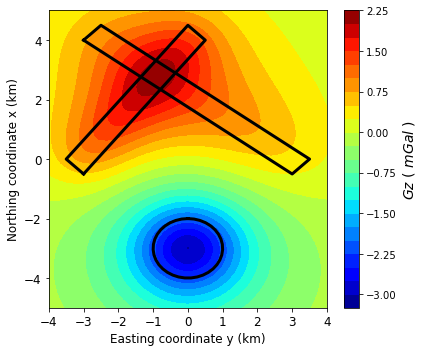

In [5]:
#Projection_model 
phi = np.linspace(0, 2.*np.pi, 36)  #36 points
x = xc/1000 + (R/1000)*np.cos(phi)
y = yc/1000 + (R/1000)*np.sin(phi)

x_p = [-3., -3.5, 0, 0.5, -3.]
y_p = [-0.5, 0, 4.5, 4, -0.5]

x_p2 = [-3, -2.5, 3.5, 3, -3.]
y_p2 = [4, 4.5, 0, -0.5, 4]

# plot of the vertical component of the gravitational atraction at z=0 
fig=plt.figure(figsize=(6,5))
fig.patch.set_facecolor('xkcd:white')
plt.plot()
plt.tricontourf(yi_plot,xi_plot,data[0],22,cmap='jet')
plt.plot(x_p,y_p,color="k", linewidth=3)
plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y, x, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
#plt.axis('scaled')
cb.set_label('$Gz$ ( $mGal$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Easting coordinate y (km)', fontsize=12)
plt.ylabel('Northing coordinate x (km)', fontsize=12)
#mpl.m2km()
#plt.plot(yi, xi, 'ko-', alpha=0.1)
plt.tight_layout();
#plt.savefig('figures/synthetic_data.png', dpi=300)

## Equivalent Layer Depth

In [6]:
# Equivalent Layer depth
zj = np.ones_like(zi)*300

## Classical Equivalent layer

In [7]:
delta_p_classical_0 = []
A = fc.sensibility_matrix(xi,yi,zi,zj,N)
I = np.identity(N)
ATA = A.T.dot(A)
mu = (np.trace(ATA)/N)*10**(-10)
AI = np.linalg.inv(ATA+mu*I)
p_0 = (AI.dot(A.T)).dot(data[0])
norm_p_0 = np.linalg.norm(p_0)
for i in range(len(data)-1):
    p = (AI.dot(A.T)).dot(data[i+1])
    norm_pl = np.linalg.norm(p-p_0)/norm_p_0
    delta_p_classical_0.append(norm_pl)

In [8]:
delta_p_classical = []
A = fc.sensibility_matrix(xi,yi,zi,zj,N)
I = np.identity(N)
ATA = A.T.dot(A)
mu = (np.trace(ATA)/N)*10**(-2)
AI = np.linalg.inv(ATA+mu*I)
p_0 = (AI.dot(A.T)).dot(data[0])
norm_p_0 = np.linalg.norm(p_0)
for i in range(len(data)-1):
    p = (AI.dot(A.T)).dot(data[i+1])
    norm_pl = np.linalg.norm(p-p_0)/norm_p_0
    delta_p_classical.append(norm_pl)

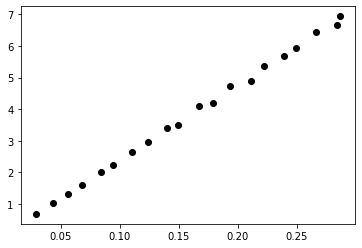

In [9]:
#plt.plot(delta_g,delta_p_classical_0, 'yo')
plt.plot(delta_g,delta_p_classical, 'ko')

## Fast Eq. Layer BCCB

In [10]:
# Predicted data
delta_p_BCCB = []
itmax = 40
rho_c_0, gzp_bccb = fc.fast_eq_bccb(xi,yi,zi,zj,shape,data[0],itmax)
norm_rho_c_0 = np.linalg.norm(rho_c_0)
for i in range(len(data)-1):
    rho_c, gzp_bccb = fc.fast_eq_bccb(xi,yi,zi,zj,shape,data[i+1],itmax)
    norm_rho_c = np.linalg.norm(rho_c-rho_c_0)/norm_rho_c_0
    delta_p_BCCB.append(norm_rho_c)

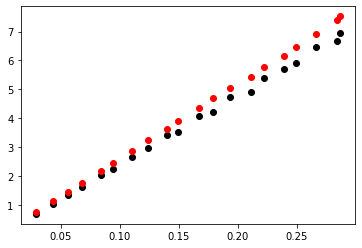

In [11]:
#plt.plot(delta_g,delta_p_classical_0, 'yo')
plt.plot(delta_g,delta_p_classical, 'ko')
plt.plot(delta_g,delta_p_BCCB, 'ro')

## Deconvolution

In [12]:
delta_p_dec = []
BTTB = fc.bttb(xi,yi,zi,zj)
cev = fc.bccb(shape,N,BTTB)
w = np.zeros(4*N, dtype='complex128')
for i in range (shape[0]):
    w[shape[1]*(2*i):shape[1]*(2*i+1)] = data[0][shape[1]*(i):shape[1]*(i+1)]
w = w.reshape(2*shape[0],2*shape[1]).T
rho_c_0_dec = np.fft.ifft2(np.fft.fft2(w)/cev)
rho_c_0_dec = np.ravel(np.real(rho_c_0_dec[:shape[1],:shape[0]]).T)
norm_rho_c_0_dec = np.linalg.norm(rho_c_0_dec)
for j in range(len(data)-1):
    w = np.zeros(4*N, dtype='complex128')
    for k in range (shape[0]):
        w[shape[1]*(2*k):shape[1]*(2*k+1)] = data[j+1][shape[1]*(k):shape[1]*(k+1)]
    w = w.reshape(2*shape[0],2*shape[1]).T
    rho_c_dec = np.fft.ifft2(np.fft.fft2(w)/cev)
    rho_c_dec = np.ravel(np.real(rho_c_dec[:shape[1],:shape[0]]).T)
    norm_rho_c_dec = np.linalg.norm(rho_c_dec-rho_c_0_dec)/norm_rho_c_0_dec
    delta_p_dec.append(norm_rho_c_dec)

## Deconvolution wiith Wiener stabilization

In [26]:
# Regularization factor of Wiener deconvolution
mu = 1e-15

delta_p_dec_wiener = []
BTTB_wiener = fc.bttb(xi,yi,zi,zj)
cev_wiener = fc.bccb(shape,N,BTTB_wiener)
w_wiener = np.zeros(4*N, dtype='complex128')
for i in range (shape[0]):
    w_wiener[shape[1]*(2*i):shape[1]*(2*i+1)] = data[0][shape[1]*(i):shape[1]*(i+1)]
w_wiener = w_wiener.reshape(2*shape[0],2*shape[1]).T
rho_c_0_dec_wiener = np.fft.ifft2((np.fft.fft2(w_wiener)*np.conj(cev_wiener))/(cev_wiener*np.conj(cev_wiener) + mu))
rho_c_0_dec_wiener = np.ravel(np.real(rho_c_0_dec_wiener[:shape[1],:shape[0]]).T)
norm_rho_c_0_dec_wiener = np.linalg.norm(rho_c_0_dec_wiener)
for j in range(len(data)-1):
    w_wiener = np.zeros(4*N, dtype='complex128')
    for k in range (shape[0]):
        w_wiener[shape[1]*(2*k):shape[1]*(2*k+1)] = data[j+1][shape[1]*(k):shape[1]*(k+1)]
    w_wiener = w_wiener.reshape(2*shape[0],2*shape[1]).T
    rho_c_dec_wiener = np.fft.ifft2((np.fft.fft2(w_wiener)*np.conj(cev_wiener))/(cev_wiener*np.conj(cev_wiener) + mu))
    rho_c_dec_wiener = np.ravel(np.real(rho_c_dec_wiener[:shape[1],:shape[0]]).T)
    norm_rho_c_dec_wiener = np.linalg.norm(rho_c_dec_wiener-rho_c_0_dec_wiener)/norm_rho_c_0_dec_wiener
    delta_p_dec_wiener.append(norm_rho_c_dec_wiener)

## Straight line fits

In [27]:
coe0 = np.polyfit(delta_g, delta_p_classical_0, 1)
poly1d_fn0 = np.poly1d(coe0)

coe = np.polyfit(delta_g, delta_p_classical, 1)
poly1d_fn = np.poly1d(coe)

coe2 = np.polyfit(delta_g, delta_p_BCCB, 1)
poly1d_fn2 = np.poly1d(coe2)

coe3 = np.polyfit(delta_g, delta_p_dec, 1)
poly1d_fn3 = np.poly1d(coe3)

coe4 = np.polyfit(delta_g, delta_p_dec_wiener, 1)
poly1d_fn4 = np.poly1d(coe4)

## Figure plots

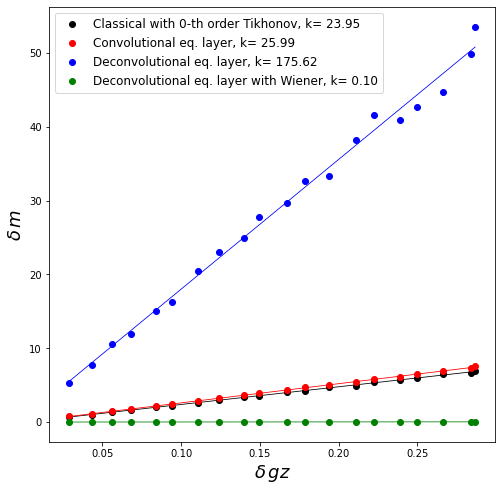

In [28]:
fig=plt.figure(figsize=(8,8))
fig.patch.set_facecolor('xkcd:white')
#plt.plot(delta_g,delta_p_classical_0, 'yo', label='Classical without Tikhonov')
plt.plot(delta_g,delta_p_classical, 'ko', label='Classical with 0-th order Tikhonov, k= %.2f' % (coe[0]))
plt.plot(delta_g,poly1d_fn(delta_g), 'k-', linewidth=0.8)
plt.plot(delta_g,delta_p_BCCB, 'ro', label='Convolutional eq. layer, k= %.2f' % (coe2[0]))
plt.plot(delta_g,poly1d_fn2(delta_g), 'r-', linewidth=0.8)
plt.plot(delta_g,delta_p_dec, 'bo', label='Deconvolutional eq. layer, k= %.2f' % (coe3[0]))
plt.plot(delta_g,poly1d_fn3(delta_g), 'b-', linewidth=0.8)
plt.plot(delta_g,delta_p_dec_wiener, 'go', label='Deconvolutional eq. layer with Wiener, k= %.2f' % (coe4[0]))
plt.plot(delta_g,poly1d_fn4(delta_g), 'g-', linewidth=0.8)
plt.xlabel('$\delta \, gz$', fontsize=18)
plt.ylabel('$\delta \, m$', fontsize=18)
plt.legend(loc='best', fontsize=12)
#plt.savefig('figures/stability_grav_no_convolution.png', dpi=300)